In [1]:
import torch
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from itertools import chain
import json

In [2]:
sys.path.append('..')
from benchmark.mnist_classification.model.mlp import Model

In [3]:
global_model = Model()
local_model = Model()

In [4]:
global_path = '../checkpoint/mnist_classification_cnum4_dist2_skew0.7_seed0/global'
local_path = '../checkpoint/mnist_classification_cnum4_dist2_skew0.7_seed0/local'

In [5]:
with open('../fedtask/mnist_classification_cnum4_dist2_skew0.7_seed0/data.json', 'r', encoding='utf-8') as f:
    task_info = json.load(f)

In [6]:
sample_size = []
for i in range(4):
    print(f'Client{i+1} sample size: ', len(task_info[f'Client{i}']['dtrain']))
    sample_size.append(len(task_info[f'Client{i}']['dtrain']))

Client1 sample size:  13339
Client2 sample size:  11625
Client3 sample size:  11454
Client4 sample size:  11580


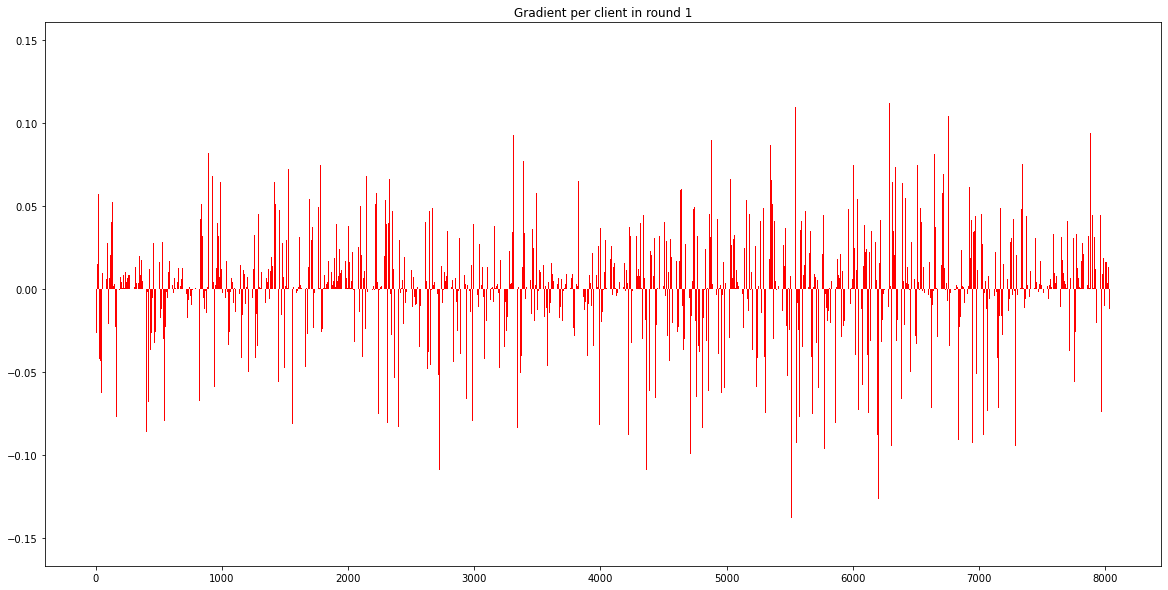

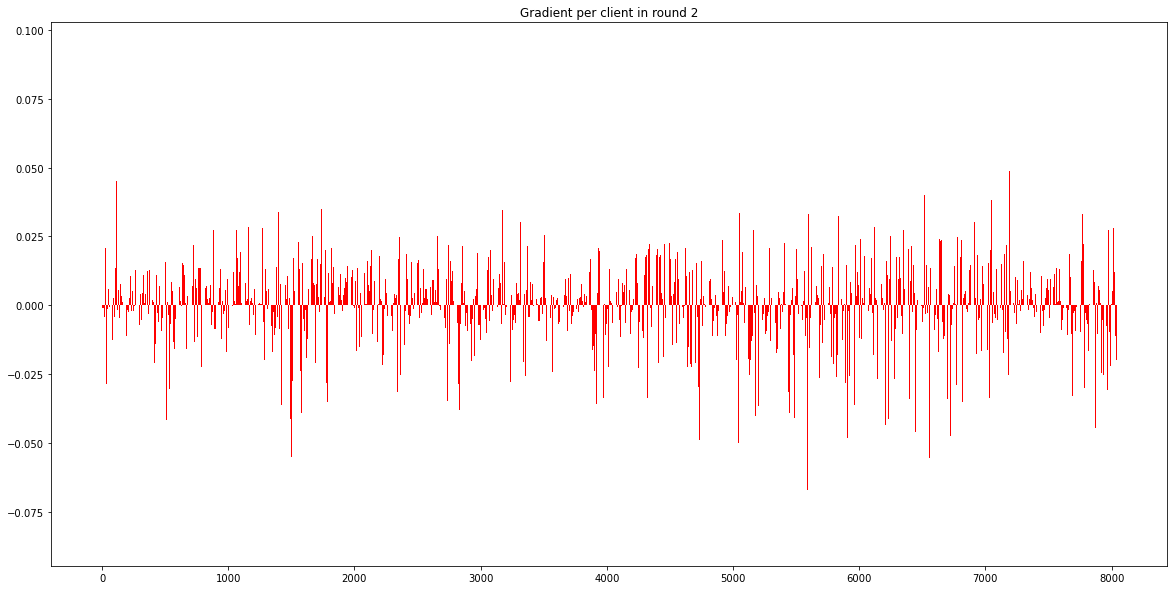

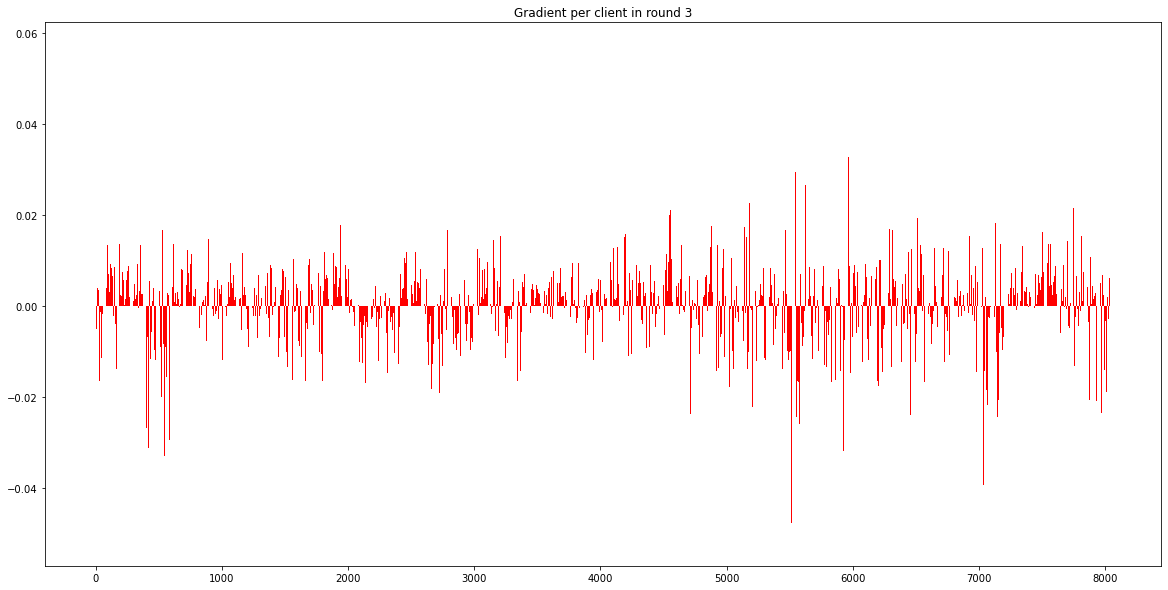

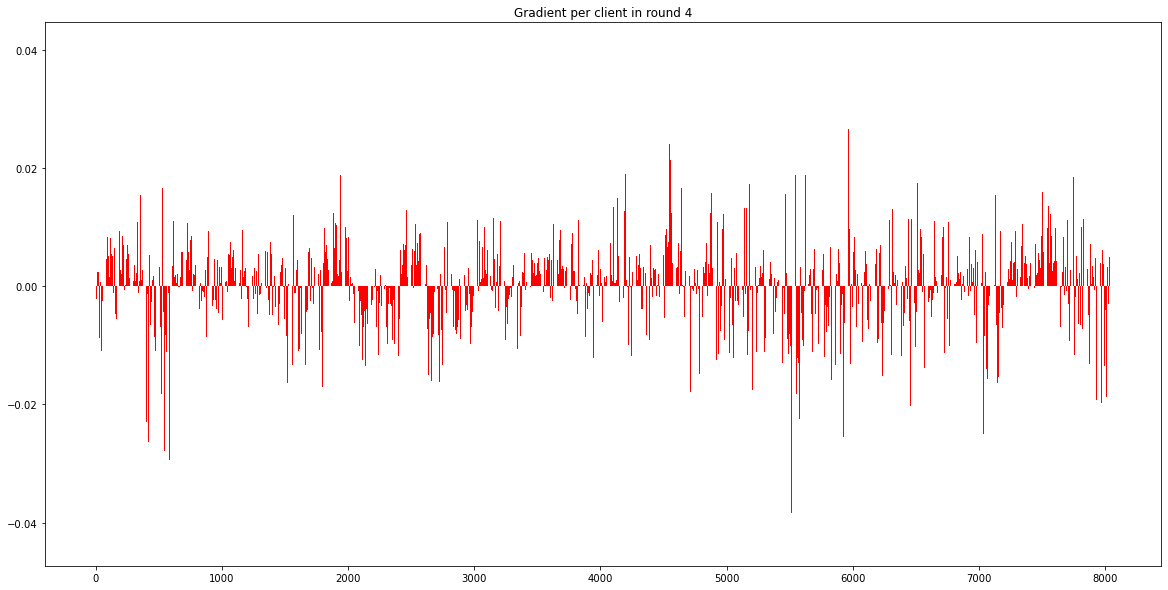

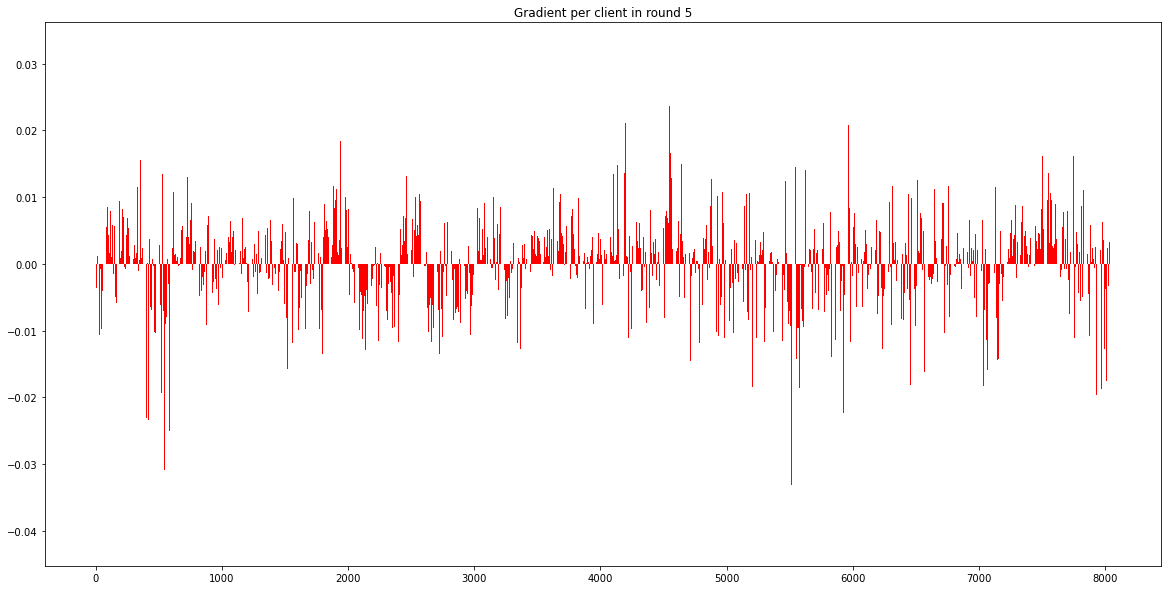

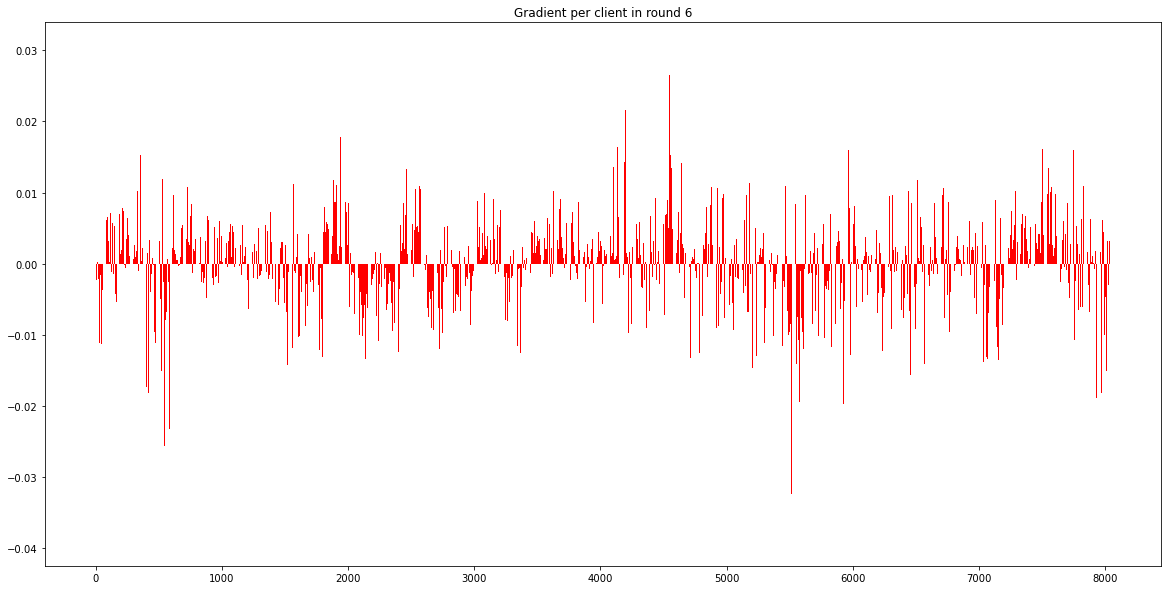

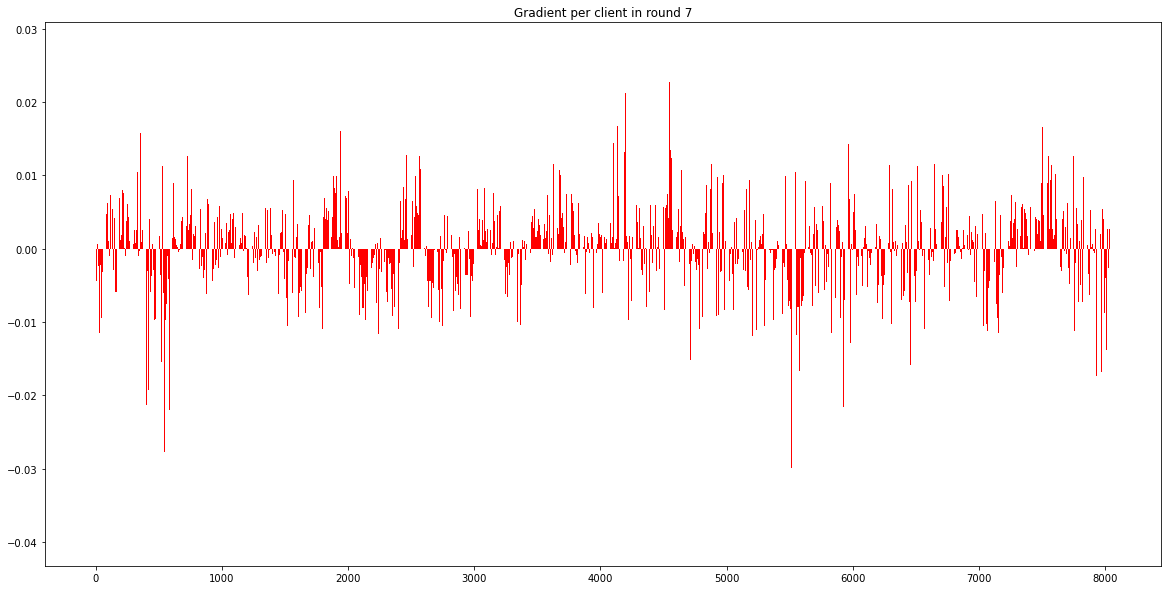

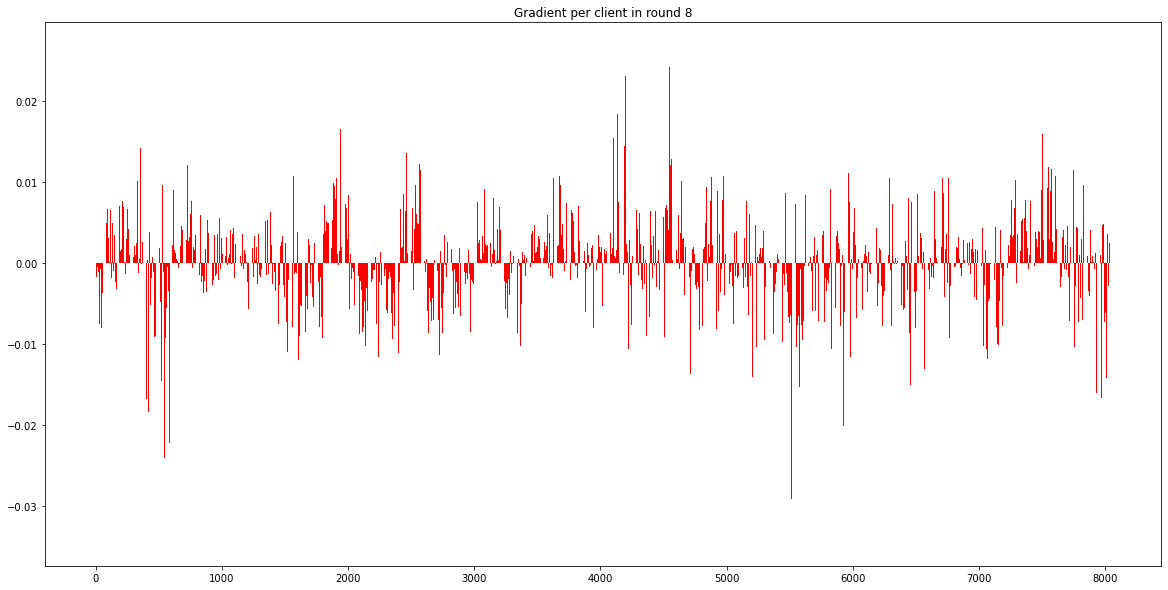

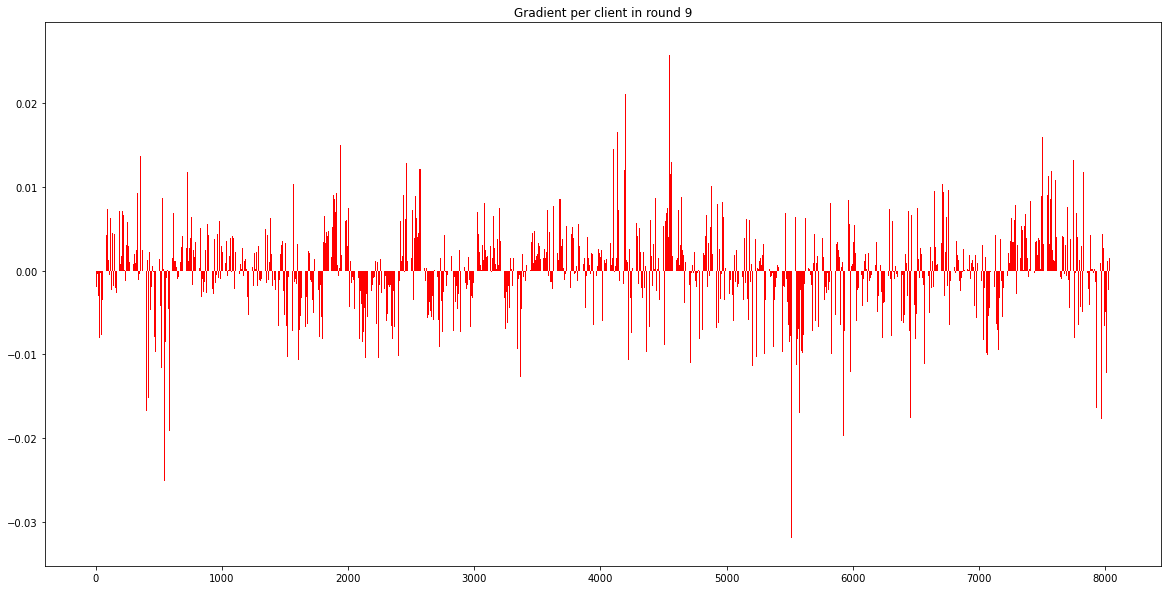

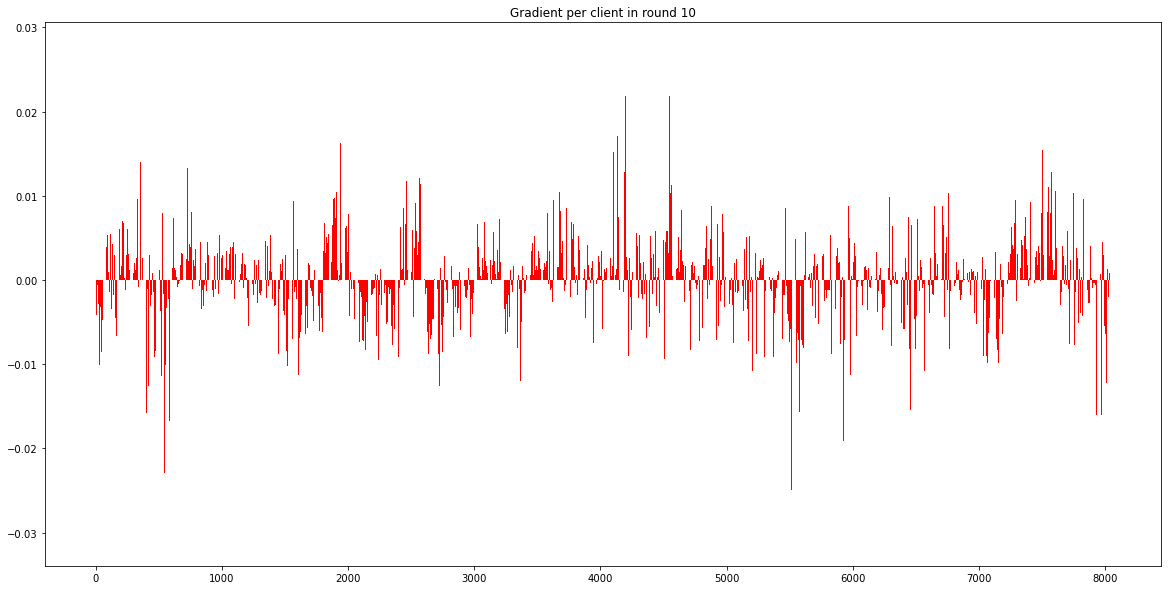

In [7]:
plot_grad_list = []
grad_list = []
for i in range(10):
    global_model.load_state_dict(torch.load(os.path.join(global_path, f"round{i}/global_model.pt")))
    for j in range(4):
        local_model.load_state_dict(torch.load(os.path.join(local_path, f'round{i+1}/client{j}_model.pt')))
        
        grad_weight = global_model.state_dict()['fc3.weight'] - local_model.state_dict()['fc3.weight']
        grad_bias = global_model.state_dict()['fc3.bias'] - local_model.state_dict()['fc3.bias']
        grad_tensor = torch.concat((torch.flatten(grad_weight), torch.flatten(grad_bias)))
        grad_list.append(grad_tensor)
    grad_list = [grad.tolist() for grad in grad_list]
    grad_list = list(chain.from_iterable(grad_list))
    plot_grad_list.append(grad_list)
    index = np.arange(2010 * 4)
    plt.figure(figsize=(20, 10)) 
    plt.bar(index, grad_list, color='red')
    plt.title(f"Gradient per client in round {i+1}")
    plt.show()
    grad_list = []
    

In [8]:
import pickle

In [9]:
const_lambda_array = np.zeros([4,])
for i in range(10):
    with open(f'../SV_result/mnist_classification_cnum4_dist2_skew0.7_seed0/const_lambda/Round{i+1}.npy', 'rb') as f:
        const_lambda = pickle.load(f)
        list_const = [itm / pow(i+1, 2) for itm in const_lambda[:-1]]
        const_lambda_array += list_const

In [10]:
opt_lambda_array = np.zeros([4,])
for i in range(10):
    with open(f'../SV_result/mnist_classification_cnum4_dist2_skew0.7_seed0/optimal_lambda/Round{i+1}.npy', 'rb') as f:
        opt_lambda = pickle.load(f)
        list_opt = [itm / pow(i+1, 2) for itm in opt_lambda[:-1]]
        opt_lambda_array += list_opt

In [11]:
exact_array = np.zeros([4,])
for i in range(10):
    with open(f'../SV_result/mnist_classification_cnum4_dist2_skew0.7_seed0/exact/Round{i+1}.npy', 'rb') as f:
        exact = pickle.load(f)
        list_exact = [itm / pow(i+1, 2) for itm in exact[:-1]]
        exact_array += list_exact

In [12]:
const_lambda_array = const_lambda_array / sum(const_lambda_array)
opt_lambda_array = opt_lambda_array / sum(opt_lambda_array)
exact_array = exact_array / sum(exact_array)

In [13]:
sample_size = [size / sum(sample_size) for size in sample_size]

In [14]:
plot_grad_list = np.array(plot_grad_list)
plot_grad_list.shape

(10, 8040)

In [15]:
sum_grad_list = np.zeros((4,))
for i in range(10):
    split_array = np.array_split(plot_grad_list[i], 4)
    sum_list = [sum(abs(item)) for item in split_array]
    sum_list = [item / pow(i+1, 2) for item in sum_list]
    sum_grad_list += sum_list 
    

In [16]:
sum_grad_list

array([47.70258972, 46.32324002, 58.8169575 , 56.76044936])

In [17]:
sum_grad_list = sum_grad_list / sum(sum_grad_list)
sum_grad_list

array([0.22758518, 0.22100441, 0.28061092, 0.27079949])

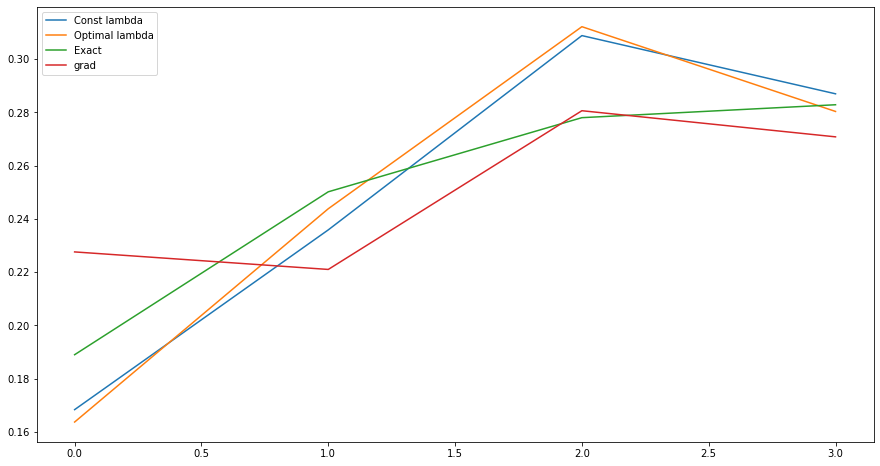

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(const_lambda_array, label="Const lambda")
plt.plot(opt_lambda_array, label="Optimal lambda")
plt.plot(exact_array, label="Exact")
# plt.plot(sample_size, label='data')
plt.plot(sum_grad_list, label='grad')
plt.legend()
plt.show()